In [2]:
%cd /content/drive/MyDrive/RL_project

/content/drive/MyDrive/RL_project


In [2]:
!pip install gym
!apt-get update
!apt-get -qq -y install xvfb freeglut3-dev ffmpeg> /dev/null
!apt-get install xvfb
!pip install pyvirtualdisplay
!pip -q install pyglet
!pip -q install pyopengl
!apt-get install swig
!pip install stable-baselines3

Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:6 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:7 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Ign:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:9 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Ign:10 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:11 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:13 https://developer.download.nvidia.com/compute/

In [3]:
!pip3 install box2d-py
!pip3 install gym[Box_2D]

In [4]:
import gym
def query_environment(name):
  env = gym.make(name)
  spec = gym.spec(name)
  print(f"Action Space: {env.action_space}")
  print(f"Observation Space: {env.observation_space}")
  print(f"Max Episode Steps: {spec.max_episode_steps}")
  print(f"Nondeterministic: {spec.nondeterministic}")
  print(f"Reward Range: {env.reward_range}")
  print(f"Reward Threshold: {spec.reward_threshold}")

query_environment("BipedalWalker-v3")

Action Space: Box([-1. -1. -1. -1.], [1. 1. 1. 1.], (4,), float32)
Observation Space: Box([-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf], [inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf inf inf inf], (24,), float32)
Max Episode Steps: 1600
Nondeterministic: False
Reward Range: (-inf, inf)
Reward Threshold: 300


In [5]:
import gym
from stable_baselines3 import PPO
from stable_baselines3 import A2C
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import CallbackList, CheckpointCallback, EvalCallback, StopTrainingOnRewardThreshold
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.callbacks import BaseCallback


In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [7]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """
    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

          # Retrieve training reward
          x, y = ts2xy(load_results(self.log_dir), 'timesteps')
          if len(x) > 0:
              # Mean training reward over the last 100 episodes
              mean_reward = np.mean(y[-100:])
              if self.verbose > 0:
                print(f"Num timesteps: {self.num_timesteps}")
                print(f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}")

              # New best model, you could save the agent here
              if mean_reward > self.best_mean_reward:
                  self.best_mean_reward = mean_reward
                  # Example for saving best model
                  if self.verbose > 0:
                    print(f"Saving new best model to {self.save_path}.zip")
                  self.model.save(self.save_path)

        return True

In [8]:
from tqdm.auto import tqdm

class ProgressBarCallback(BaseCallback):
    """
    :param pbar: (tqdm.pbar) Progress bar object
    """
    def __init__(self, pbar):
        super(ProgressBarCallback, self).__init__()
        self._pbar = pbar

    def _on_step(self):
        # Update the progress bar:
        self._pbar.n = self.num_timesteps
        self._pbar.update(0)

# this callback uses the 'with' block, allowing for correct initialisation and destruction
class ProgressBarManager(object):
    def __init__(self, total_timesteps): # init object with total timesteps
        self.pbar = None
        self.total_timesteps = total_timesteps
        
    def __enter__(self): # create the progress bar and callback, return the callback
        self.pbar = tqdm(total=self.total_timesteps)
            
        return ProgressBarCallback(self.pbar)

    def __exit__(self, exc_type, exc_val, exc_tb): # close the callback
        self.pbar.n = self.total_timesteps
        self.pbar.update(0)
        self.pbar.close()

In [11]:
log_dir='./'
os.makedirs(log_dir, exist_ok=True)
#save a checkpoint every 1000 steps
# checkpoint_callback=CheckpointCallback(save_freq=1000, save_path='./logs/checkpoints/', name_prefix='rl_model')

#create environment 
env = gym.make("BipedalWalker-v3")
# Create and wrap the environment
# env = make_vec_env('BipedalWalker-v3', n_envs=1, monitor_dir=log_dir)
env=Monitor(env, log_dir)

callback_on_best = SaveOnBestTrainingRewardCallback(check_freq=100, log_dir=log_dir, verbose=0)


# Create the callback list
# callback = CallbackList([checkpoint_callback, plotting_callback, callback_on_best])

# Instantiate the agent
model_A2C = A2C('MlpPolicy', env, verbose=0)
# Train the agent
with ProgressBarManager(5000000) as progress_callback:
  # This is equivalent to callback=CallbackList([progress_callback, callback_on_best])
  model_A2C.learn(5000000, callback=[progress_callback, callback_on_best])

  0%|          | 0/5000000 [00:00<?, ?it/s]

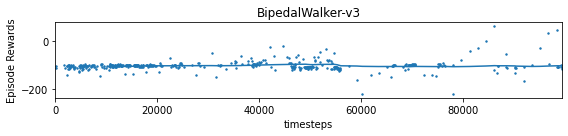

In [12]:
from stable_baselines3.common import results_plotter

# Helper from the library
results_plotter.plot_results([log_dir], 1e5, results_plotter.X_TIMESTEPS, "BipedalWalker-v3")

In [13]:
x, y=results_plotter.ts2xy(load_results(log_dir), 'timesteps')

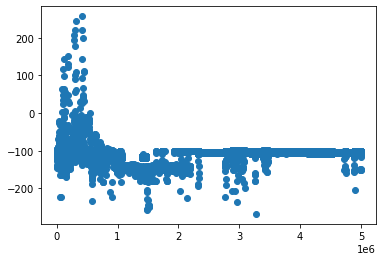

In [15]:
plt.scatter(x,y)

In [16]:
x, y=results_plotter.window_func(x, y, 5, np.mean)

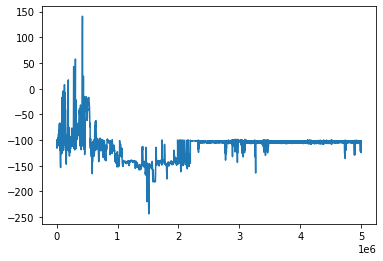

In [17]:
plt.plot(x, y)

In [21]:
# Save the agent
model_A2C.save("a2c_bipedal")
#load the trained agent
model=A2C.load("a2c_bipedal", env=env)

#evaluate the agent
mean_reward, std_reward = evaluate_policy(model, model.get_env(), n_eval_episodes=100)
print('mean_reward: ', mean_reward)
print('std_reward: ', std_reward)

mean_reward:  -100.96485257
std_reward:  0.49996118784972143


In [22]:
model_A2C=A2C.load('/content/drive/MyDrive/RL_project/best_model.zip', env=env)


In [23]:
#evaluate the agent
mean_reward, std_reward = evaluate_policy(model_A2C, model_A2C.get_env(), n_eval_episodes=100)
print('mean_reward: ', mean_reward)
print('std_reward: ', std_reward)

mean_reward:  -100.31907151000003
std_reward:  1.1341996438311417


In [44]:
model2=A2C('MlpPolicy', env, verbose=0)
model2.set_parameters('/content/drive/MyDrive/RL_project/best_model.zip', exact_match=True)
#evaluate the agent
mean_reward, std_reward = evaluate_policy(model2, model2.get_env(), n_eval_episodes=100)
print('mean_reward: ', mean_reward)
print('std_reward: ', std_reward)

mean_reward:  -100.41238272000001
std_reward:  1.5527554267697543


## Prepare video recording

In [9]:
# Set up fake display; otherwise rendering will fail
import os
os.system("Xvfb :1 -screen 0 1024x768x24 &")
os.environ['DISPLAY'] = ':1'

In [10]:
import base64
from pathlib import Path

from IPython import display as ipythondisplay

def show_videos(video_path='', prefix=''):
  """
  Taken from https://github.com/eleurent/highway-env

  :param video_path: (str) Path to the folder containing videos
  :param prefix: (str) Filter the video, showing only the only starting with this prefix
  """
  html = []
  for mp4 in Path(video_path).glob("{}*.mp4".format(prefix)):
      video_b64 = base64.b64encode(mp4.read_bytes())
      html.append('''<video alt="{}" autoplay 
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{}" type="video/mp4" />
                </video>'''.format(mp4, video_b64.decode('ascii')))
  ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

In [11]:
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv

def record_video(env_id, model, video_length=500, prefix='', video_folder='./videos/'):
  """
  :param env_id: (str)
  :param model: (RL model)
  :param video_length: (int)
  :param prefix: (str)
  :param video_folder: (str)
  """
  eval_env = DummyVecEnv([lambda: gym.make(env_id)])
  # Start the video at step=0 and record 500 steps
  eval_env = VecVideoRecorder(eval_env, video_folder=video_folder,
                              record_video_trigger=lambda step: step == 0, video_length=video_length,
                              name_prefix=prefix)

  obs = eval_env.reset()
  for _ in range(video_length):
    action, _ = model.predict(obs)
    obs, _, _, _ = eval_env.step(action)

  # Close the video recorder
  eval_env.close()

In [27]:
record_video('BipedalWalker-v3', model_A2C, video_length=600, prefix='a2c-bipedal')

Saving video to /content/drive/MyDrive/RL_project/videos/a2c-bipedal-step-0-to-step-600.mp4


In [28]:
show_videos('/content/drive/MyDrive/RL_project/videos', prefix='a2c')

# Change hyperparamters in the A2C algorithm

In [1]:
%cd /content/drive/MyDrive/RL_project/hyper_a2c

/content/drive/MyDrive/RL_project/hyper_a2c


In [53]:
log_dir='./'
os.makedirs(log_dir, exist_ok=True)

#create environment 
# env = gym.make("BipedalWalker-v3")
# Create and wrap the environment
env = make_vec_env('BipedalWalker-v3', n_envs=16, monitor_dir=log_dir)
# env=Monitor(env, log_dir)

callback_on_best = SaveOnBestTrainingRewardCallback(check_freq=100, log_dir=log_dir, verbose=0)


# Instantiate the agent
new_A2C = A2C('MlpPolicy', env=env, learning_rate=0.00096, n_steps=8, gamma=0.99, \
                gae_lambda=0.9, ent_coef=0.0, vf_coef=0.4, max_grad_norm=0.5, \
                use_rms_prop=True, use_sde=True, normalize_advantage=False, \
                policy_kwargs=dict(log_std_init=-2, ortho_init=False), verbose=1)

# Train the agent
with ProgressBarManager(500000) as progress_callback:
  # This is equivalent to callback=CallbackList([progress_callback, callback_on_best])
  new_A2C.learn(500000, callback=[progress_callback, callback_on_best])


Using cpu device


  0%|          | 0/500000 [00:00<?, ?it/s]

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 95.1     |
|    ep_rew_mean        | -119     |
| time/                 |          |
|    fps                | 1249     |
|    iterations         | 100      |
|    time_elapsed       | 10       |
|    total_timesteps    | 12800    |
| train/                |          |
|    entropy_loss       | -0.13    |
|    explained_variance | 0.919    |
|    learning_rate      | 0.00096  |
|    n_updates          | 99       |
|    policy_loss        | -0.0245  |
|    std                | 0.136    |
|    value_loss         | 0.0203   |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 112      |
|    ep_rew_mean        | -118     |
| time/                 |          |
|    fps                | 1332     |
|    iterations         | 200      |
|    time_elapsed       | 19       |
|    total_timesteps    | 25600    |
|

In [55]:
# Save the agent
new_A2C.save("a2c_bipedal")
#load the trained agent
model_new_A2C=A2C.load("a2c_bipedal", env=env)

#evaluate the agent
mean_reward, std_reward = evaluate_policy(model_new_A2C, model_new_A2C.get_env(), n_eval_episodes=100)
print('mean_reward: ', mean_reward)
print('std_reward: ', std_reward)

mean_reward:  0.40240891000000034
std_reward:  67.85137424272874


In [56]:
model1_new_A2C=A2C.load('/content/drive/MyDrive/RL_project/hyper_a2c/best_model.zip', env=env)
mean_reward, std_reward = evaluate_policy(model1_new_A2C, model1_new_A2C.get_env(), n_eval_episodes=100)
print('mean_reward: ', mean_reward)
print('std_reward: ', std_reward)

mean_reward:  1.7728225600000003
std_reward:  2.6753239393368693


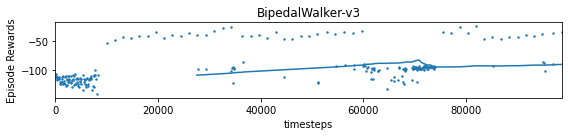

In [57]:
from stable_baselines3.common import results_plotter

# Helper from the library
results_plotter.plot_results([log_dir], 1e5, results_plotter.X_TIMESTEPS, "BipedalWalker-v3")

Text(0.5, 1.0, 'Episode rewards for hyperparamers-tunned A2C')

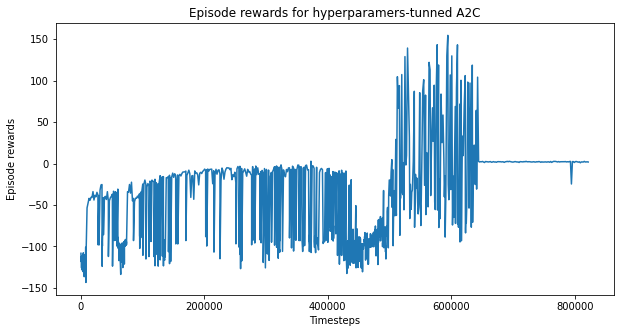

In [63]:
#plot the episode rewards with timesteps
x, y=results_plotter.ts2xy(load_results(log_dir), 'timesteps')
plt.figure(figsize=(10, 5))
plt.plot(x,y)
plt.xlabel('Timesteps')
plt.ylabel('Episode rewards')
plt.title('Episode rewards for hyperparamers-tunned A2C')

Text(0.5, 1.0, 'Averaged Episode rewards for hyperparamers-tunned A2C')

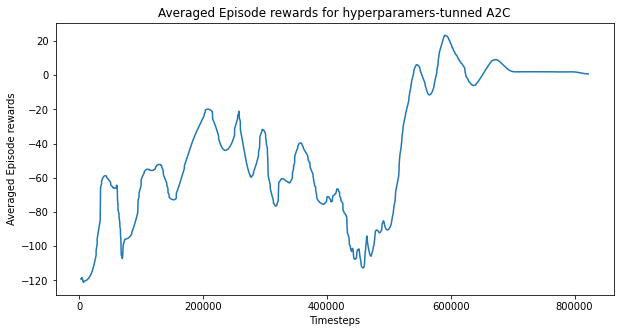

In [66]:
x, y=results_plotter.window_func(x, y, 10, np.mean)
plt.figure(figsize=(10, 5))
plt.plot(x,y)
plt.xlabel('Timesteps')
plt.ylabel('Averaged Episode rewards')
plt.title('Averaged Episode rewards for hyperparamers-tunned A2C')

In [17]:
log_dir='./'
env=make_vec_env('BipedalWalker-v3', n_envs=16, monitor_dir=log_dir)
model1_new_A2C=A2C.load('/content/drive/MyDrive/RL_project/hyper_a2c/best_model.zip', env=env)
mean_reward, std_reward = evaluate_policy(model1_new_A2C, model1_new_A2C.get_env(), n_eval_episodes=100)
print('mean_reward: ', mean_reward)
print('std_reward: ', std_reward)

mean_reward:  -0.46069173999999996
std_reward:  7.962369165162421
